In [1]:
import sys
sys.path.append("../")

In [2]:
CHECK_OPENCV2 = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if CHECK_OPENCV2 in sys.path:
    sys.path.remove(CHECK_OPENCV2)

import numpy as np
import tensorflow as tf
from utils import network_placeholders, config_parser
from models.detector.detector import Detector
from models.loss import detection_loss as loss_fn
from data import dataloader
from cfg import config_reader

In [3]:
import cv2
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [30]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [31]:
np.set_printoptions(linewidth=500)

In [4]:
!realpath ../cfg/darknet.cfg

/home/karan/knapanda_local/playground/yolov3-tf2/cfg/darknet.cfg


In [5]:
model_config_file = "/home/karan/knapanda_local/playground/yolov3-tf2/cfg/darknet.cfg"
parsed_config = config_parser.parse(model_config_file)
#training_config = config_reader.reader("/home/karan/knapanda_local/playground/yolov3-tf2/cfg/config.json")
#train_dataset, validation_dataset = dataloader.tf_dataloader(training_config)

In [6]:
detection_model = Detector(parsed_config, 1)
detection_model = detection_model.build_model((416, 416, 3))

In [38]:
latest_checkpoint_path = "/home/karan/Checkpoint/ckpt-457"
# latest_checkpoint_path = tf.train.latest_checkpoint("/home/karan/Checkpoint/")

In [39]:
new_optimizer = tf.keras.optimizers.SGD()
checkpoint = tf.train.Checkpoint(optimizer=new_optimizer, model=detection_model)
checkpoint.restore(latest_checkpoint_path)

In [40]:
image = Image.open("../data/sample/dog.jpg")

In [41]:
resized_image = image.resize((416, 416),
                             PIL.Image.LANCZOS)

In [42]:
image_array = np.array(resized_image)

In [43]:
input_image = np.expand_dims(image_array/255, axis=0)

In [44]:
input_tensor = tf.convert_to_tensor(input_image)

In [45]:
detection_results = detection_model(input_tensor)

In [46]:
# postprocess the detection_results
detection_result_1 = detection_results[0]
detection_result_2 = detection_results[1]
detection_result_3 = detection_results[2]

In [47]:
detection_result_1_r = tf.reshape(detection_result_1, [1, 3, 13, 13, 6])
detection_result_2_r = tf.reshape(detection_result_2, [1, 3, 26, 26, 6])
detection_result_3_r = tf.reshape(detection_result_3, [1, 3, 52, 52, 6])

In [48]:
det_1_bboxes = detection_result_1_r[:, :, :, :, :4]
det_1_objectness = detection_result_1_r[:, :, :, :, 4]
det_1_classes = detection_result_1_r[:, :, :, :, 5:]

In [49]:
grid_x_num = 13
grid_y_num = 13
batch_size = 1
anchor_size = 3

anchors_tensor = tf.constant(
#     [[10.0, 13.0], 
#      [16.0, 30.0], 
#      [33.0, 23.0]]
    
    [[116.0, 90.0],[156.0, 198.0],[373.0, 326.0]]
)

intermediate_center_x_offset = tf.broadcast_to(
    tf.range(grid_x_num, dtype=tf.float32),
    [grid_y_num, grid_x_num]
)   
center_x_offsets = tf.broadcast_to(
    intermediate_center_x_offset,
    [batch_size, anchor_size, grid_y_num, grid_x_num]
)   
intermediate_center_y_offset = tf.broadcast_to(
    tf.range(grid_y_num, dtype=tf.float32),
    [grid_x_num, grid_y_num]
)   
intermediate_center_y_offset = tf.transpose(intermediate_center_y_offset)
center_y_offsets = tf.broadcast_to(
    intermediate_center_y_offset,
    [batch_size, anchor_size, grid_y_num, grid_x_num]
)

def get_anchor_wh_offsets(w_index,
                          h_index,
                          anchors,
                          grid_x,
                          grid_y,
                          batch_size):
    anchor_size = anchors.shape[0]
    w_offsets = tf.broadcast_to(
        tf.expand_dims(
            tf.broadcast_to(
                tf.expand_dims(
                    tf.broadcast_to(
                        tf.expand_dims(anchors[:, w_index], axis=-1),
                        [anchor_size, grid_y]),
                    axis=-1),
                [anchor_size, grid_y, grid_x]),
            axis=0),
        [batch_size, anchor_size, grid_y, grid_x]
    )

    h_offsets = tf.broadcast_to(
        tf.expand_dims(
            tf.broadcast_to(
                tf.expand_dims(
                    tf.broadcast_to(
                        tf.expand_dims(anchors[:, h_index], axis=-1),
                        [anchor_size, grid_y]),
                    axis=-1),
                [anchor_size, grid_y, grid_x]),
            axis=0),
        [batch_size, anchor_size, grid_y, grid_x]
    )
    return w_offsets, h_offsets

In [50]:
w_offsets, h_offsets = get_anchor_wh_offsets(0,
                                             1,
                                             anchors_tensor,
                                             13,
                                             13,
                                             1)

In [51]:
det_1_x = det_1_bboxes[..., 0]
det_1_y = det_1_bboxes[..., 1] 
det_1_w = det_1_bboxes[..., 2]
det_1_h = det_1_bboxes[..., 3]

In [52]:
pred_1_x = (tf.math.sigmoid(det_1_x) + center_x_offsets) / grid_x_num
pred_1_y = (tf.math.sigmoid(det_1_y) + center_y_offsets) / grid_y_num
pred_1_w = (tf.exp(det_1_w) * w_offsets)/416
pred_1_h = (tf.exp(det_1_h) * h_offsets)/416

In [53]:
pred_objectness = tf.math.sigmoid(det_1_objectness)
pred_classes = tf.math.sigmoid(det_1_classes)

In [54]:
mask = tf.reshape(pred_classes > 0.7, [1, 3, 13, 13])

In [55]:
predicted_bboxes = tf.stack([pred_1_x, pred_1_y, pred_1_w, pred_1_h], axis=-1)

In [56]:
bboxes = tf.boolean_mask(predicted_bboxes, mask)

In [57]:
bboxes_scaled = bboxes * 416

In [58]:
bboxes_np = tf.cast(bboxes_scaled, dtype=tf.int32).numpy()

In [60]:
pred_classes

<tf.Tensor: shape=(1, 3, 13, 13, 1), dtype=float32, numpy=
array([[[[[4.40285065e-11],
          [5.28579636e-04],
          [1.36383780e-04],
          [2.24171657e-14],
          [9.92165446e-01],
          [6.61292310e-09],
          [1.19573894e-15],
          [9.99999881e-01],
          [9.43766281e-07],
          [1.90395304e-15],
          [1.00000000e+00],
          [2.19571757e-05],
          [2.61332852e-15]],

         [[1.00000000e+00],
          [4.20233191e-05],
          [2.73287959e-15],
          [1.00000000e+00],
          [4.00565077e-05],
          [3.06267695e-15],
          [1.00000000e+00],
          [4.32048437e-05],
          [4.56475076e-15],
          [1.00000000e+00],
          [5.59105065e-05],
          [1.16370841e-14],
          [1.00000000e+00]],

         [[9.79633041e-05],
          [1.26932400e-13],
          [1.00000000e+00],
          [4.48662962e-04],
          [1.64647133e-11],
          [1.00000000e+00],
          [8.77525937e-03],
          [4.

207 214 74 92
-12 301 130 109


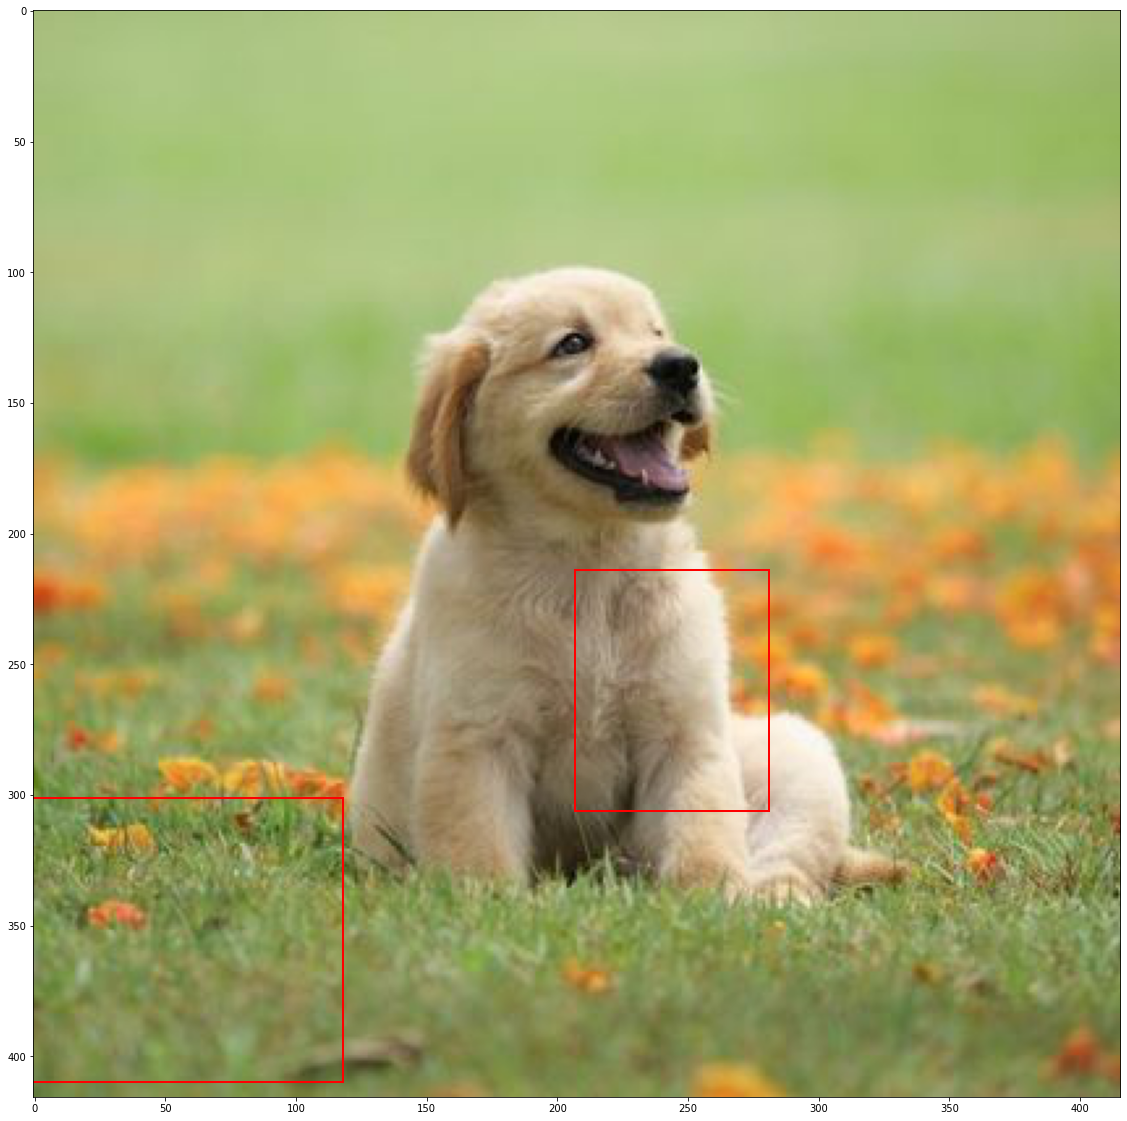

In [44]:
im = Image.open("/home/karan/knapanda_local/playground/yolov3-tf2/data/sample/dog.jpg")
im = np.array(im, dtype=np.uint8)

fig,ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(im)

for box in bboxes_np:
    cx, cy, w, h = box
    x = int(cx-(w/2))
    y = int(cy-(h/2))
    print(x, y, w, h)
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [76]:
objectness_heatmap = pred_objectness.numpy()

In [87]:
objectness_heatmap_anchor1 = np.array(objectness_heatmap[0][0, :, :] * 255, dtype=np.uint8)
objectness_heatmap_anchor2 = np.array(objectness_heatmap[0][1, :, :] * 255, dtype=np.uint8)
objectness_heatmap_anchor3 = np.array(objectness_heatmap[0][2, :, :] * 255, dtype=np.uint8)

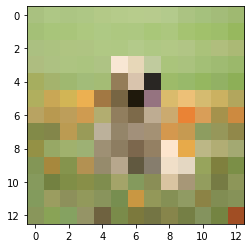

In [92]:
plt.imshow(cv2.resize(im, (13, 13)))

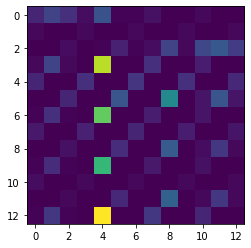

In [89]:
plt.imshow(objectness_heatmap_anchor1)